In [164]:
import pandas as pd
import random
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
## import the COVID-19 data set
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
data = pd.read_csv(url) # coronavirus data

## Choose aim country as Czechia
## Modify the format of data set 
df = data[data["Country/Region"]=="Czechia"]
df.drop(columns="Province/State", inplace=True)
melt = df.melt(id_vars=['Country/Region', 'Lat', 'Long'], var_name="Date" ,value_name='TotalCases')       
melt.head()

## Choose a 20 day length of infection numbers
## And do a 7 day average 
t_data = np.linspace(0, 20, 20)
data_infect = []
for i in range(20):
    infect = (np.sum(melt['TotalCases'][i+400:i+407])- np.sum(melt['TotalCases'][i+399:i+406]))/7
    data_infect.append(infect)
    
## Here we assume the true infect cases is three times as pcr postive cases 
## And change the unit to thousand ## 
data_infect = np.array(data_infect)/1000*3

C:\Users\Feng\Anaconda3\lib\site-packages\pandas\core\frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


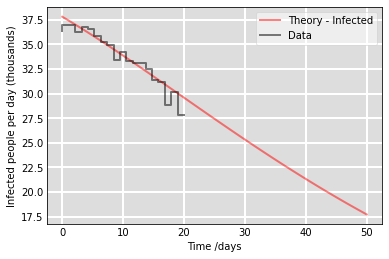

I0 : 554.2875026870337 R0 : 1354.6360525545274 beta : 0.08509206973372535 gamma : 0.07348971789803994


In [193]:
## The Total population of Czechia, which is 10000 thousand.
N = 10000

## A simple random method to fit the SIR model with data
criteria, I_para, R_para, beta_para, gamma_para, Daily = [], [], [], [], [], []

for i in range(10000):
    ## Random number setting
    RanA = random.uniform(0.95, 1.05)
    RanB = random.uniform(0.95, 1.05)
    RanC = random.uniform(0.95, 1.05)
    RanD = random.uniform(0.95, 1.05)
    ## Initial number guessing
    I0, R0, beta, gamma = 562.99*RanA , 1386.39*RanB , 0.082*RanC , 0.07*RanD
    S0 = N - I0 - R0
    ## Collect initial number 
    I_para.append(I0)
    R_para.append(R0)
    beta_para.append(beta)
    gamma_para.append(gamma)
    ## Calculate the infection numbers per day 
    ## And collect daily infection numbers
    daily_I  = []
    for i in range(50):
        S0 += -beta * S0 * I0 / N
        I0 += beta * S0 * I0 / N - gamma * I0
        R0 += gamma * I0
        D_I = beta * S0 * I0 / N
        daily_I.append(D_I)    
    ## Collect theory daily infected number 
    Daily.append(daily_I)
    ## Define loss function
    loss = np.sum(np.abs((data_infect - np.array(daily_I[:20]))))
    ## Collect the value from loss function
    criteria.append(loss)
##Choose the index of the minimun loss function value.
index = criteria.index(min(criteria))

# A grid of time points (in days)
t = np.linspace(0, 50, 50)

## Plot the daily infect data and theory predicted infect number 
fig = plt.figure(0, facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, Daily[index], 'r', alpha=0.5, lw=2, label='Theory - Infected')
ax.step(t_data, data_infect, 'black', alpha=0.5, lw=2, label='Data')
ax.set_xlabel('Time /days')
ax.set_ylabel('Infected people per day (thousands)')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
plt.show()


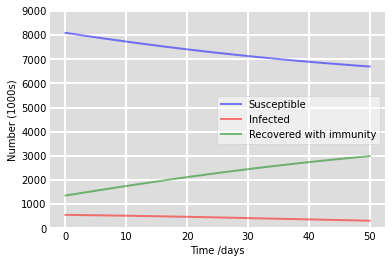

In [194]:
## Initial number of infected and recovered individuals, I0 and R0.
I0, R0, beta, gamma = I_para[index] , R_para[index], beta_para[index], gamma_para[index]

## Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0

## The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

## Initial conditions vector
y0 = S0, I0, R0
## Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

## Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,9000)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()